# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import spearmanr, pearsonr, chi2_contingency

import numpy as np
import plotly.graph_objects as go
from optbinning import BinningProcess

(CVXPY) Feb 11 01:01:56 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 11 01:01:56 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
data = pd.read_csv('./data/application_train_vf.csv')
# validation = pd.read_csv('./data/application_test_vf.csv')

# bureau = pd.read_csv('./data/bureau.csv')
# bureau_balance = pd.read_csv('./data/bureau_balance.csv')

# previous_app = pd.read_csv('./data/previous_application.csv')

# credit_card = pd.read_csv('./data/credit_card_balance.csv')
# install_pay = pd.read_csv('./data/installments_payments.csv')
# pos_cash = pd.read_csv('./data/POS_CASH_balance.csv')

# Dates

In [3]:
data['date_mensuelle'] = pd.to_datetime(data['date_mensuelle'])

In [4]:
data.drop(columns='Unnamed: 0',inplace = True)

In [5]:
data.shape

(306107, 123)

## drop NaN or remplace them by mean

In [6]:
for i in data.select_dtypes(include=['float', 'int']).columns:
    if data[i].isna().sum() / len(data[i]) * 100 > 30:
        print(i, data[i].isna().sum() / len(data[i]) * 100)
        # supprimer les NaN
        data.drop(columns = i, axis = 1, inplace= True)
    else : data[i].fillna(data[i].mode()[0], inplace = True)

OWN_CAR_AGE 65.97758300202217
EXT_SOURCE_1 56.37375166200054
APARTMENTS_AVG 50.71788622932504
BASEMENTAREA_AVG 58.49327196045827
YEARS_BEGINEXPLUATATION_AVG 48.75354042867364
YEARS_BUILD_AVG 66.4741413950024
COMMONAREA_AVG 69.85498534826058
ELEVATORS_AVG 53.267974923801155
ENTRANCES_AVG 50.31802604971464
FLOORSMAX_AVG 49.73064974012355
FLOORSMIN_AVG 67.82562960010715
LANDAREA_AVG 59.35146860411555
LIVINGAPARTMENTS_AVG 68.33492863606516
LIVINGAREA_AVG 50.16677174974764
NONLIVINGAPARTMENTS_AVG 69.41232967557096
NONLIVINGAREA_AVG 55.15326340135965
APARTMENTS_MODE 50.71788622932504
BASEMENTAREA_MODE 58.49327196045827
YEARS_BEGINEXPLUATATION_MODE 48.75354042867364
YEARS_BUILD_MODE 66.4741413950024
COMMONAREA_MODE 69.85498534826058
ELEVATORS_MODE 53.267974923801155
ENTRANCES_MODE 50.31802604971464
FLOORSMAX_MODE 49.73064974012355
FLOORSMIN_MODE 67.82562960010715
LANDAREA_MODE 59.35146860411555
LIVINGAPARTMENTS_MODE 68.33492863606516
LIVINGAREA_MODE 50.16677174974764
NONLIVINGAPARTMENTS_MODE 

In [7]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

if 'TARGET' in numerical_cols:
    numerical_cols.remove('TARGET')

len(numerical_cols), len(categorical_cols)

(60, 16)

In [8]:
data.shape

(306107, 78)

In [9]:
dates = data.select_dtypes(include=['datetime64[ns]']).columns.tolist()
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = data.select_dtypes(exclude=[np.number, 'datetime64[ns]']).columns.tolist()

numeric_columns_specified = [col for col in numeric_columns ]
categorical_columns_specified = [col for col in categorical_columns ]

significant_numeric_vars = []
for col in numeric_columns_specified:
    corr, p_value = spearmanr(data[col], data['TARGET'])
    if p_value <= 0.05:
        significant_numeric_vars.append(col)

significant_categorical_vars = []
for col in categorical_columns_specified:
    contingency_table = pd.crosstab(data[col], data['TARGET'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    if p <= 0.05:
        significant_categorical_vars.append(col)

len(significant_numeric_vars), len(significant_categorical_vars)

(43, 16)

In [10]:
cols_to_keep = significant_numeric_vars + significant_categorical_vars + dates
len(cols_to_keep)

60

In [11]:
data = data[cols_to_keep]
data.shape

(306107, 60)

# Ma liste

In [12]:
sous_liste = ["date_mensuelle", 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'TARGET']
len(sous_liste) # 32 

list_filtre = [col for col in sous_liste if col in data.columns]
len(list_filtre)

11

In [13]:
sous_data = data[list_filtre]
print(sous_data.shape)
sous_data.head()

(306107, 11)


,date_mensuelle,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,2013-01-01,9,0,0,0,0,0,Transport: type 3,0.616187,0.651260,0
1,2013-01-01,10,0,0,0,0,0,University,0.548623,0.413597,0
2,2013-01-01,10,0,0,0,0,0,Government,0.582081,0.399676,0
3,2013-01-01,10,0,0,0,0,0,Self-employed,0.607885,0.627991,0
4,2013-01-01,15,1,1,1,1,1,Industry: type 3,0.091309,0.463275,0


In [14]:
# var num 
float_columns = sous_data.select_dtypes(include='float').columns

# var quali
obj_columns = sous_data.select_dtypes(include='object').columns

# var indicatrices 
int_columns = sous_data.select_dtypes(include = 'int').columns 

print(len(float_columns))
print(len(obj_columns))
print(len(int_columns))
# oublie pas dropper 'target'

2
1
7


In [15]:
print(f"variables type float", float_columns)

print(f"variables type object", obj_columns)

print(f"variables type int", int_columns)

variables type float Index(['EXT_SOURCE_2', 'EXT_SOURCE_3'], dtype='object')
variables type object Index(['ORGANIZATION_TYPE'], dtype='object')
variables type int Index(['HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'TARGET'],
      dtype='object')


## Variables numériques 

### discrétiser les var num

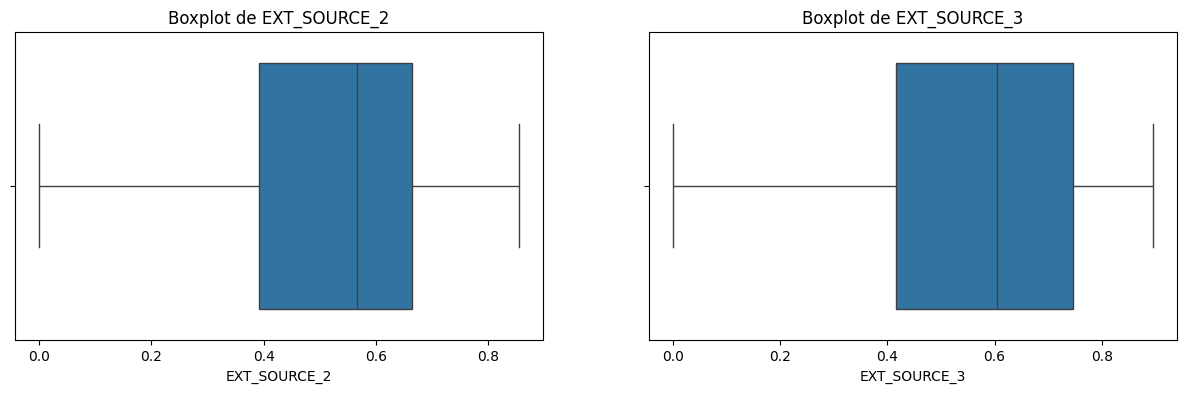

In [16]:
# float_columns = sous_data.select_dtypes(include='float').columns
num_cols = 2
num_rows = (len(float_columns) + 1) // 2  # Ajoutez 1 pour gérer les cas impairs

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

for i, col in enumerate(float_columns):
    sns.boxplot(x=sous_data[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')
plt.show()

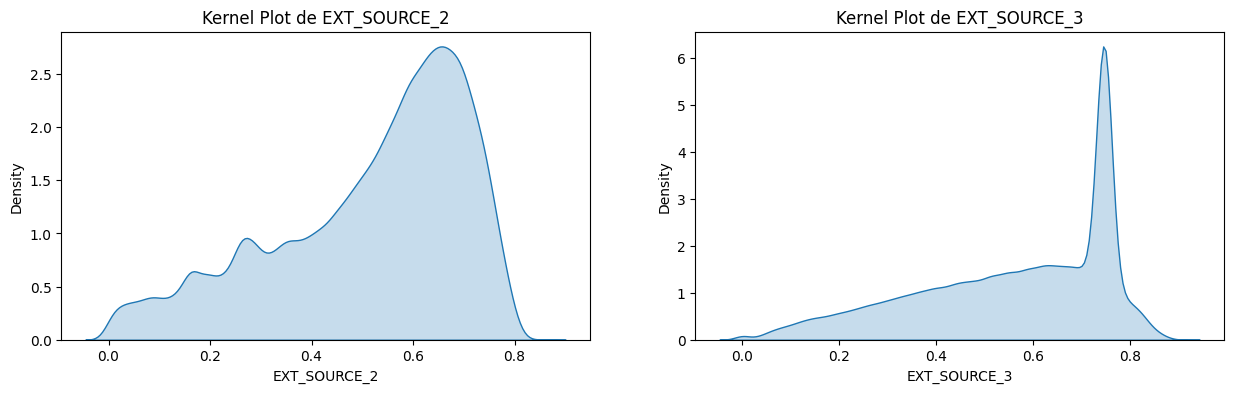

In [17]:
num_cols = 2
num_rows = (len(float_columns) + 1) // 2  # Ajoutez 1 pour gérer les cas impairs

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))

fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

for i, col in enumerate(float_columns):
    sns.kdeplot(x=data[col], ax=axes[i], fill=True)
    axes[i].set_title(f'Kernel Plot de {col}')

plt.show()

### Corrélation entre var num 

In [18]:
corr_matrix = sous_data.select_dtypes(include='number').corr(method='spearman')
col_corr = np.transpose(corr_matrix[np.abs(corr_matrix['TARGET'])>0.05]).columns
corr = corr_matrix.loc[col_corr,col_corr]
corr

# proche de 0 indique qu'il n'y a pas de corrélation linéaire entre les variables

,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
EXT_SOURCE_2,1.000000,0.053142,-0.143575
EXT_SOURCE_3,0.053142,1.000000,-0.100629
TARGET,-0.143575,-0.100629,1.000000


### Discrétisation : BinningProcess

In [19]:
# Effectuer le processus de binning
binning_process = BinningProcess(variable_names=list(float_columns), max_n_bins=4)
binning_table = binning_process.fit_transform(sous_data[float_columns].values, sous_data['TARGET'].values)

# Ajouter les colonnes discrétisées à sous_data
for i, column in enumerate(float_columns):
    bin_column_name = f"{column}_BIN"
    sous_data[bin_column_name] = binning_table[:, i]

# Afficher les premières lignes de sous_data pour vérifier les modifications
sous_data.head()

C:\Users\jinzhou\AppData\Local\Temp\ipykernel_5220\463342360.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sous_data[bin_column_name] = binning_table[:, i]
C:\Users\jinzhou\AppData\Local\Temp\ipykernel_5220\463342360.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sous_data[bin_column_name] = binning_table[:, i]


,date_mensuelle,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,TARGET,EXT_SOURCE_2_BIN,EXT_SOURCE_3_BIN
0,2013-01-01,9,0,0,0,0,0,Transport: type 3,0.616187,0.651260,0,0.144656,0.235349
1,2013-01-01,10,0,0,0,0,0,University,0.548623,0.413597,0,0.144656,0.235349
2,2013-01-01,10,0,0,0,0,0,Government,0.582081,0.399676,0,0.144656,-0.430969
3,2013-01-01,10,0,0,0,0,0,Self-employed,0.607885,0.627991,0,0.144656,0.235349
4,2013-01-01,15,1,1,1,1,1,Industry: type 3,0.091309,0.463275,0,-1.172119,0.235349


###### Ainsi, le graphique reflète la stabilité de l'impact de chaque classe spécifique sur la variable cible.

###### Dans le contexte d'une var cible bianire, la moyenne de la variable binaiire est équivalente à la proportion de 1 dans la var >> ce qui est une mesure valide de la stabilité 

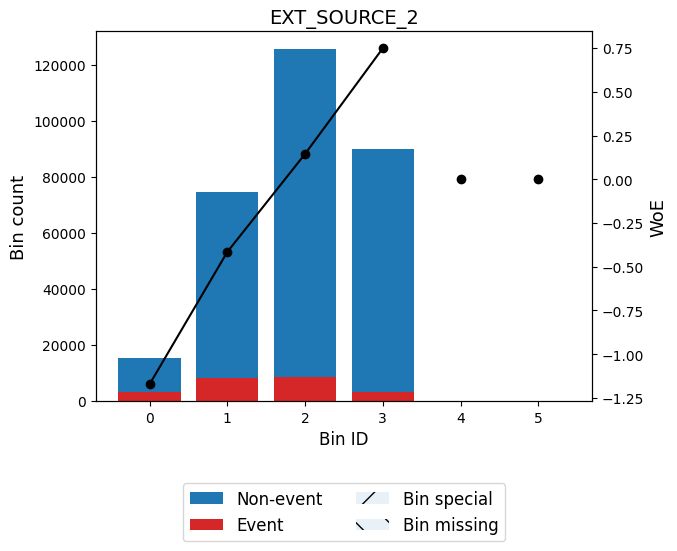

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28514125
    IV (Jeffrey)             0.29294498
    JS (Jensen-Shannon)      0.03546858
    Hellinger                0.03602838
    Triangular               0.13771985
    KS                       0.21770087
    HHI                      0.31750763
    HHI (normalized)         0.18100916
    Cramer's V               0.15532289
    Quality score            0.76000082

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1  1138.701124 1.280995e-249       1.0 1.110223e-16
        1      2  1223.030540 6.027811e-268       1.0 1.110223e-16
        2      3   867.706916 1.028233e-190       1.0 1.110223e-16



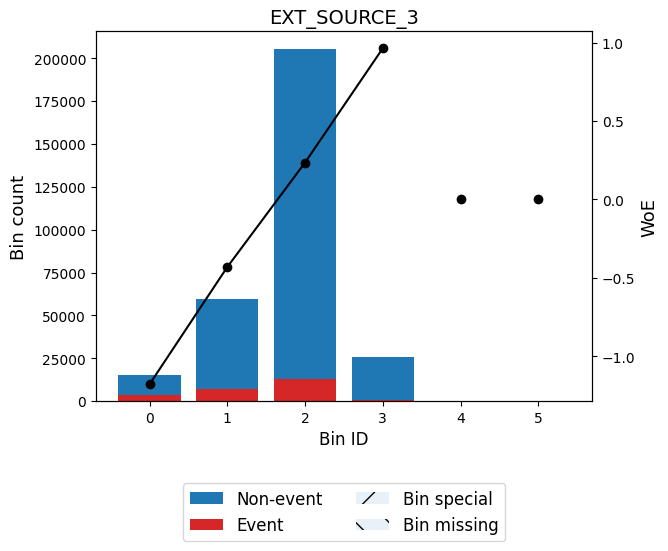

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.23552938
    IV (Jeffrey)             0.24301407
    JS (Jensen-Shannon)      0.02931519
    Hellinger                0.02983036
    Triangular               0.11347547
    KS                       0.19730519
    HHI                      0.49764845
    HHI (normalized)         0.39717814
    Cramer's V               0.14641667
    Quality score            0.50544610

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1  1039.711114 4.194374e-228       1.0 1.110223e-16
        1      2  1826.220030  0.000000e+00       1.0 1.110223e-16
        2      3   397.143955  2.304970e-88       1.0 1.110223e-16



In [20]:
for variable in float_columns:
    optb = binning_process.get_binned_variable(name=variable)
    optb.binning_table.build()
    optb.binning_table.plot()
    optb.binning_table.analysis()

#####    Gini index               0.28514125 pour 'EXT_SOURCE_2'
#####    Gini index               0.23552938 pour 'EXT_SOURCE_3'

In [33]:
stability_df

EXT_SOURCE_3_BIN,-1.1787955255359006,-0.43096870530152503,0.23534888899786685,0.9645270456825706,stability
date_mensuelle,,,,,
2013-01-01,0.231707,0.091954,0.064560,0.051282,0.755101
2013-02-01,0.216867,0.090461,0.071163,0.029412,0.791572
2013-03-01,0.210526,0.115570,0.064186,0.033333,0.732352
2013-04-01,0.185185,0.112698,0.065451,0.026820,0.698928
2013-05-01,0.190476,0.110260,0.068075,0.020243,0.742387
...,...,...,...,...,...
2020-08-01,0.217647,0.129485,0.060606,0.040323,0.715044
2020-09-01,0.137500,0.117199,0.069536,0.051282,0.428455
2020-10-01,0.252809,0.128637,0.058460,0.022472,0.878458


In [22]:
# Créer une fonction pour calculer la stabilité de l'impact sur la cible
def calculate_stability(column):
    stability_df = sous_data.groupby(['date_mensuelle', column])['TARGET'].mean().unstack()
    
    # Calcul de la stabilité pour chaque combinaison de 'date' et de la var disctétisée spécifiée 'column'
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    return stability_df

# Tracer la stabilité de l'impact sur la cible au fil du temps avec Plotly
for column in float_columns:
    stability_df = calculate_stability(f"{column}_BIN")  # Utilisez la colonne discrétisée
    
    # Créer un graphique en barres empilées avec Plotly
    fig = go.Figure()
    
    for class_label in stability_df.columns[:-1]:
        fig.add_trace(go.Scatter(x=stability_df.index, y=stability_df[class_label],
                                 mode='lines+markers', name=f'Classe {class_label}'))
    
    # Ajouter une annotation pour le maximum de stabilité
    max_stability_date = stability_df['stability'].idxmax()
    max_stability_value = stability_df['stability'].max()
    fig.add_annotation(text=f'Max Stability\nDate: {max_stability_date}\nValue: {max_stability_value:.2f}',
                       x=max_stability_date, y=max_stability_value + 0.1, showarrow=True,
                       arrowhead=2, arrowcolor='red', ax=0, ay=-40)
    
    # Personnaliser la mise en page
    fig.update_layout(title=f'Stabilité de l\'impact sur la cible pour {column}',
                      xaxis_title='Date',
                      yaxis_title='Proportion de la cible (TARGET)',
                      legend_title=f'Classes de {column}_BIN',
                      barmode='stack') # pour empiler les lignes les unes sur les autres pour chaque date
    
    # Afficher le graphique interactif
    fig.show()

In [38]:
print(data['EXT_SOURCE_2'].min())
print(data['EXT_SOURCE_2'].max())

8.173616518884397e-08
0.8549996664047012


In [39]:
print(data['EXT_SOURCE_3'].min())
print(data['EXT_SOURCE_3'].max())

0.0005272652387098
0.8960095494948396


<a class="anchor" id="section_3_1"></a>

<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">Analyse des résultats</h3>
</div>

<div>
'EXT_SOURCE_2' : 0.15 et 0.75 les 2 classes sont les plus stables dans le temps 
(-1.17, 0.15] & (0.15, 0.75]
<div>
'EXT_SOURCE_3' : la classe 0.24 est la plus stable dans le temps (donc l'intervalle (0.24, 0.96])
<div>
4 points de coupure pour diviser 'EXT_SOURCE_3' en classes discrètes :
<div>
Classe 1 : <=-0.43
<div>
Classe 2 : (-0.43, -1.17]
<div>
Classe 3 : (-1.17,0.24]
<div>
Classe 4 : (0.24, 0.96]

# var catégorielles : 'ORGANIZATION_TYPE'

In [ ]:
for col in obj_columns:
    print(f"{col} : {sous_data[col].nunique()}z")

ORGANIZATION_TYPE : 58


# variables indicatrices

In [24]:
for col in int_columns:
    print(f"{col} : {sous_data[col].nunique()}")

# "HOUR_APPR_PROCESS_START" : Label encoding 

HOUR_APPR_PROCESS_START : 24
REG_REGION_NOT_LIVE_REGION : 2
REG_REGION_NOT_WORK_REGION : 2
REG_CITY_NOT_LIVE_CITY : 2
REG_CITY_NOT_WORK_CITY : 2
LIVE_CITY_NOT_WORK_CITY : 2
TARGET : 2


In [25]:
from sklearn.preprocessing import LabelEncoder

# Créer un label encoder
label_encoder = LabelEncoder()

# Appliquer le label encoding à la variable "HOUR_APPR_PROCESS_START"
sous_data['HOUR_APPR_PROCESS_START'] = label_encoder.fit_transform(sous_data['HOUR_APPR_PROCESS_START'])

C:\Users\jinzhou\AppData\Local\Temp\ipykernel_5220\2026607247.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### OHE

In [26]:
int_columns = int_columns.drop("HOUR_APPR_PROCESS_START")

# Sélectionnez uniquement les colonnes de votre liste dans le DataFrame
selected_columns = sous_data[int_columns]

# Effectuez le codage one-hot
sous_data_encoded = pd.get_dummies(selected_columns, columns=int_columns, drop_first=True)

# Concaténez le DataFrame encodé avec le reste du DataFrame original
sous_data = pd.concat([sous_data.drop(columns=selected_columns.columns), sous_data_encoded], axis=1)

In [ ]:
sous_data.head()